## Exercise 1

Create a vectorized version of log and exp math function for 1D array A = [2, 5, 10, 3, 8]

Results should be: 
+ [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
+ [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]

In [1]:
import numpy as np
from numba import vectorize

@vectorize()
def vectorized_log(x):
    return np.log(x)

@vectorize()
def vectorized_exp(x):
    return np.exp(x)

A = np.array([2,5,10,3,8]).astype(np.float32)
print("Vectorized version of log: ", vectorized_log(A))
print("Vectorized version of exp: ",vectorized_exp(A))

Vectorized version of log:  [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
Vectorized version of exp:  [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]


## Exerice 2
Compute the value of a Gaussian probability density function at $x$ with $mean = 1$, $\sigma = 1$, lower and upper bound in $(-3, 3)$ and $size = 100000$

In [2]:
from numba import jit

@jit(nopython=True) 
def gaussian_pdf(x,mu,sigma):
    return (1/sigma*np.sqrt(2*np.pi))*(np.exp(-0.5*((x-mu)/sigma)**2))

x = np.linspace(-3,3,100000).astype(np.float32)
print("Value of a Gaussian probability density with mean=1, sd=1, lower and upper bound in (−3,3) and size=100000:\n", gaussian_pdf(x,1,1))

Value of a Gaussian probability density with mean=1, sd=1, lower and upper bound in (−3,3) and size=100000:
 [0.00084088 0.00084108 0.00084128 ... 0.33931662 0.33927601 0.33923525]


## Exercise 3

Create a "zero suppression" function. A common operation when working with waveforms is to force all samples values below a certain absolute magnitude to be zero, as a way to eliminate low amplitude noise. 
Plot the data before and after the application of the zero_suppress function.

$thresold = 15$

Text(0.5, 1.0, 'With zero suppression')

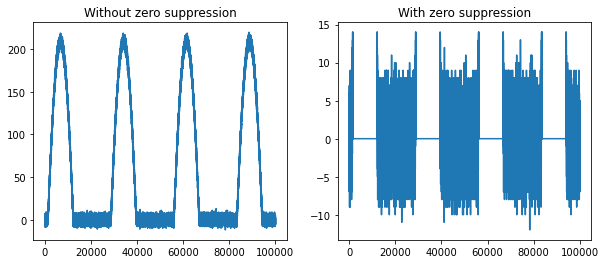

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt

n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
data = ((pulses * 300) + noise).astype(np.int16)

#put your code here
threshold = 15
@jit 
def suppression_data(threshold,data):
    x = np.where(data<threshold,data,0)
    return x
    
fig = plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(data)
plt.title("Without zero suppression")

plt.subplot(1,2,2)
plt.plot(suppression_data(threshold,data))
plt.title("With zero suppression")    

## Exercise 4

Calculate the Sigmoid kernel between the matrix X and Y defined as below. The Sigmoid kernel is defined as:

$k(x,y) = \tanh(\alpha x^T y + c) $

In [5]:
import math
X = np.random.rand(3,3)
Y = np.random.rand(3,3)

jit(nopython=True)
def k(x,y):
    res = np.array([[0 for i in range(3)] for j in range(3)]).astype(np.float64)  
  
    # explicit for loops 
    for m in range(len(x)): 
        for n in range(len(y[0])): 
            for o in range(len(y)): 

                # resulted matrix 
                res[m][n] += x[m][o] * y[o][n]
            res[m][n] = math.tanh(alpha*res[m][n]+c)
    return res  

alpha = 0.5
c = 0.5
X = X.T

print("Sigmoid kernel between the matrix X and Y:\n",k(X,Y))


Sigmoid kernel between the matrix X and Y:
 [[0.87966799 0.68897896 0.83996614]
 [0.80374924 0.68503051 0.75271233]
 [0.85650165 0.66484412 0.80978166]]


## Exercise 5

Create a kernel function similar to the ```double_kernel``` see during the lecture and create a new function that takes a 3 dimensional matrix as input calculating the $cos$ for each element and then returns the result. The shape of the matrix must be $256X256X256$. The matrix can be randomly generated

In [ ]:
import os
os.environ["NUMBA_ENABLE_CUDASIM"] = "1"
from numba import njit, cuda

@cuda.jit()
def kernel_3D(io_array):
    x,y,z = cuda.grid(3)
    if x < io_array.shape[0] and y < io_array.shape[1] and z < io_array.shape[2]:
        io_array[x][y][z] = np.cos(io_array[x][y][z]) 

  
data = numpy.random.random((256,256,256))

threadsperblock = (64,64,64) 
blockspergrid_x = int(math.ceil(data.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(data.shape[1] / threadsperblock[1]))
blockspergrid_z = int(math.ceil(data.shape[2] / threadsperblock[2]))

blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)

kernel_3D[blockspergrid, threadsperblock](data)
print(data)

## Exercise 6

Create a matrix multiplication kernel function, called ```matmul``` that takes as input two 2D matrices:
+ A of shape $24x12$
+ B of shape $12x22$
and that computes the multiplication and put the results into a third matrix C of shape $24x12$

A and B must be randomly generated and only int values are allowed.


In [ ]:
from numba import cuda

# complete the code
@cuda.jit
def matmul(A, B, C):
    row, col = cuda.grid(2)
    if row < C.shape[0] and col < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[row, k] * B[k, col]
        C[row, col] = tmp

A = np.full((24, 12), 3, np.float) 
B = np.full((12, 22), 4, np.float) 

threadsperblock = (16, 16)
blockspergrid_x = int(math.ceil(A.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(B.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)

A_mem = cuda.to_device(A)
B_mem = cuda.to_device(B)

C_mem = cuda.device_array((24, 22))

matmul[blockspergrid, threadsperblock](A_mem, B_mem, C_mem)

C = C_mem.copy_to_host()

print(C)        